<h3> Imports

In [1]:
import numpy as np
import pandas as pd
import random
import os
import numpy as np
import matplotlib.pyplot as plt 
import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 
from tensorflow.keras.utils import to_categorical, plot_model
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from skimage.transform import resize
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from imblearn.over_sampling import SMOTE

In [2]:
import tensorflow as tf
from tensorflow import keras
import sys

print("GPUs Available: ", len(tf.config.experimental.list_physical_devices("GPU")))
print(tf.test.is_built_with_cuda())
print(tf.version.VERSION)
print(sys.version)
print(tf.test.gpu_device_name())
print(tf.test.is_gpu_available())

GPUs Available:  1
True
2.6.2
3.6.13 |Anaconda, Inc.| (default, Mar 16 2021, 11:37:27) [MSC v.1916 64 bit (AMD64)]
/device:GPU:0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


<h3> EDA & Preprocessing

In [3]:
train_path = "data/train/"
test_path = "data/test"
emotions = os.listdir(train_path)
len_train = {}
len_test = {}

for emotion in emotions:
    file_train = os.listdir(os.path.join(train_path, emotion))
    len_train[emotion] = len(file_train)
    
    file_test = os.listdir(os.path.join(test_path, emotion))
    len_test[emotion] = len(file_test)

print("Train: ", len_train)
print("Test: ", len_test)

total_train = sum(len_train.values())
total_test = sum(len_test.values())

print()
print("Total Train: ", total_train)
print("Total Test: ", total_test)


Train:  {'angry': 3995, 'disgust': 436, 'fear': 4097, 'happy': 7215, 'neutral': 4965, 'sad': 4830, 'surprise': 3171}
Test:  {'angry': 958, 'disgust': 111, 'fear': 1024, 'happy': 1774, 'neutral': 1233, 'sad': 1247, 'surprise': 831}

Total Train:  28709
Total Test:  7178


In [4]:
# Class Distribution

# Create Subplots
data_split = ["Train", "Test"]
fig = make_subplots(
    rows=3, cols=1,
    subplot_titles=data_split
)

all_len = [len_train, len_test]
all_total = [total_train, total_test]

for i in range(2):
    # Bar Chart
    fig.add_trace(
        go.Bar(
            x=list(all_len[i].keys()),
            y=list(all_len[i].values()),
            name=data_split[i],
            marker_color=["#935d39", "#926f48", "#90825c", "#8e9590", "#8ba0a5", "#88acb9", "#85b8cd"],
        ), row=i+1, col=1
    )

    # Update Axes
    fig.update_xaxes(ticks="outside", linecolor="Black", row=i+1, col=1)
    fig.update_yaxes(ticks="outside", linecolor="Black", row=i+1, col=1)

# Update Layout
fig.update_layout(
    title="Class Distribution", title_x=0.5, font_size=14, font_family="Cambria",
    width=650, height=900,
    plot_bgcolor="White",
    showlegend=False
)

# Show
fig.show(renderer="iframe_connected")

In [5]:
class CFG:
    batch_size = 64
    img_shape = 96
    epoch = 25

In [6]:
train_datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip = True,
    rescale = 1./255,
    fill_mode="nearest",
    validation_split = 0.2
)
train_generator = train_datagen.flow_from_directory(
    directory = "data/train/",
    target_size = (CFG.img_shape,CFG.img_shape),
#     shuffle=True
    batch_size = CFG.batch_size,
    class_mode = "categorical",
    subset = "training"
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255, 
    validation_split = 0.2
)

validation_generator = validation_datagen.flow_from_directory(
    directory = "data/test/",
    target_size = (CFG.img_shape,CFG.img_shape),
    batch_size = CFG.batch_size,
    class_mode = "categorical",
    subset = "validation"
)
print("done")

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.
done


shape:  (48, 48, 3)


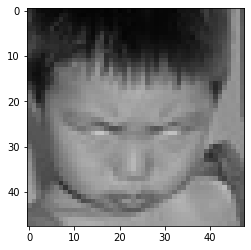

In [7]:
img_array = cv2.imread("data/train/angry/angry_1.jpg")
print("shape: ", img_array.shape) # rgb
plt.imshow(img_array)
#its very pixilated because the size of the image is 48x48

shape:  (96, 96, 3)


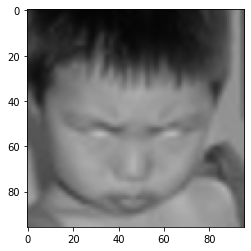

In [8]:
#change size of image
resized_img_array = cv2.resize(img_array, (CFG.img_shape,CFG.img_shape))
plt.imshow(cv2.cvtColor(resized_img_array, cv2.COLOR_BGR2RGB))
print("shape: ", resized_img_array.shape) # rgb

In [9]:
input_shape = (CFG.img_shape, CFG.img_shape, 3)
base_model = MobileNetV2(weights="imagenet",  include_top=False, input_shape=input_shape)

#freeze weights
for layer in base_model.layers:
    layer.trainable=False

base_model.summary()

Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 48, 48, 32)   0           bn_Conv1[0][0]                   
________________________________________________________________________________

In [10]:
#add my own layers
base_output = base_model.output
############
#final_output = layers.Dense(128)(base_output) #adding new layer after base_output
#final_output = layers.Activation('relu')(final_output)
#final_output = layers.Dense(64)(final_output)
#final_output = layers.Activation('relu')(final_output)
###########
final_output = GlobalAveragePooling2D()(base_output)
final_output = Dropout(0.5)(final_output)
final_output_prediction = Dense(7, activation="softmax")(final_output)

new_model = keras.Model(inputs= base_model.input, outputs= final_output_prediction)
new_model.compile(
    loss='categorical_crossentropy', 
    optimizer="adam", 
    metrics=['accuracy']
)

new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 48, 48, 32)   0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [13]:
#Callback
model_checkpoint = ModelCheckpoint(
    "model_checkpoints/mobilenet_{epoch:02d}_{val_accuracy:.2f}.h5", 
    monitor="val_accuracy", 
    mode="max", 
    verbose=1,
    save_best_only=True
)
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=5,
    restore_best_weights=True,
    verbose=1)


callbacks = [model_checkpoint, early_stopping_callback]

In [14]:
%%time
history = new_model.fit(
    train_generator,
    steps_per_epoch= train_generator.samples // CFG.batch_size,
    epochs=CFG.epoch,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // CFG.batch_size,
    callbacks=callbacks
)

Epoch 1/25
358/358 [==============================] - 736s 2s/step - loss: 1.9955 - accuracy: 0.2911 - val_loss: 1.5957 - val_accuracy: 0.3949

Epoch 00001: val_accuracy improved from -inf to 0.39489, saving model to mobilenet_01_0.39.h5


D:\Anaconda\envs\cuda_tf\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



Epoch 2/25
358/358 [==============================] - 49s 138ms/step - loss: 1.6685 - accuracy: 0.3579 - val_loss: 1.5402 - val_accuracy: 0.4155

Epoch 00002: val_accuracy improved from 0.39489 to 0.41548, saving model to mobilenet_02_0.42.h5
Epoch 3/25
358/358 [==============================] - 48s 134ms/step - loss: 1.6210 - accuracy: 0.3737 - val_loss: 1.5174 - val_accuracy: 0.4212

Epoch 00003: val_accuracy improved from 0.41548 to 0.42116, saving model to mobilenet_03_0.42.h5
Epoch 4/25
358/358 [==============================] - 48s 134ms/step - loss: 1.6206 - accuracy: 0.3760 - val_loss: 1.5742 - val_accuracy: 0.4084

Epoch 00004: val_accuracy did not improve from 0.42116
Epoch 5/25
358/358 [==============================] - 48s 135ms/step - loss: 1.6131 - accuracy: 0.3822 - val_loss: 1.5285 - val_accuracy: 0.4155

Epoch 00005: val_accuracy did not improve from 0.42116
Epoch 6/25
358/358 [==============================] - 48s 135ms/step - loss: 1.6078 - accuracy: 0.3767 - val_los

In [17]:
train_loss, train_accuracy = new_model.evaluate(train_generator)
test_loss, test_accuracy   = new_model.evaluate(validation_generator)

23/23 [==============================] - 2s 80ms/step - loss: 1.5278 - accuracy: 0.4246


<h3> Before Changing

In [ ]:
# def rename_files(folder_path, new_name):
#     file_list = os.listdir(folder_path)
#     file_count = len(file_list)
    
#     for i, filename in enumerate(file_list):
#         extension = os.path.splitext(filename)[1]  # Get the file extension
#         new_filename = f"{new_name}_{i+1}{extension}"  # Create the new filename with an auto-incremented ID
#         old_filepath = os.path.join(folder_path, filename)
#         new_filepath = os.path.join(folder_path, new_filename)
#         os.rename(old_filepath, new_filepath)
#         print(f"Renamed {filename} to {new_filename}")

# angry_dir = os.path.join("data/test", "angry")
# disgust_dir = os.path.join("data/test", "disgust")
# fear_dir = os.path.join("data/test", "fear")
# happy_dir = os.path.join("data/test", "happy")
# neutral_dir = os.path.join("data/test", "neutral")
# sad_dir = os.path.join("data/test", "sad")
# surprise_dir = os.path.join("data/test", "surprise")


# rename_files(angry_dir, "angry")
# rename_files(disgust_dir, "disgust")
# rename_files(fear_dir, "fear")
# rename_files(happy_dir, "happy")
# rename_files(neutral_dir, "neutral")
# rename_files(sad_dir, "sad")
# rename_files(surprise_dir, "surprise")

In [ ]:
def preprocess_data(folder_path, img_size):
    collected_data = []
    for category in img_calsses:
        path = os.path.join(folder_path, category)
        class_label = img_calsses.index(category)
        for img in os.listdir(path):
            #get array
            img_array = cv2.imread(os.path.join(path, img))
            #normalize between -1 to 1
            img_array = preprocess_input(img_array)
            #resize image
            img_array = resize(img_array, output_shape=(img_size, img_size))
            collected_data.append([img_array, class_label])
    return collected_data
        
train_data = preprocess_data("data/train/", 96)
print("done train data")
test_data = preprocess_data("data/test/", 96)
print("done train data")

In [52]:
train_x = []
label_train_y = [] #use this if we use sparce_categorical_crossentropy
test_x = []
label_test_y = []
#train data
for features,label in train_data:
    train_x.append(features)
    label_train_y.append(label)
    
train_x = np.array(train_x).reshape(-1, 96, 96, 3)
print(train_x.shape, np.array(label_train_y).shape)

for features,label in test_data:
    test_x.append(features)
    label_test_y.append(label)
test_x = np.array(test_x).reshape(-1, 96, 96, 3)
print(test_x.shape, np.array(label_test_y).shape)

print("done")

(28709, 96, 96, 3) (28709,)
(7178, 96, 96, 3) (7178,)
done


In [53]:
matrix_train_y = to_categorical(label_train_y, num_classes=7) #use this for categorical_crossentropy
matrix_test_y = to_categorical(label_test_y, num_classes=7)

In [58]:
#save data in .npy
np.save('numpy_data/train_x.npy', train_x)
np.save('numpy_data/test_x.npy', test_x)
np.save('numpy_data/label_train_y.npy', label_train_y)
np.save('numpy_data/matrix_train_y.npy', matrix_train_y)
np.save('numpy_data/label_test_y.npy', label_test_y)
np.save('numpy_data/matrix_test_y.npy', matrix_test_y)
print("done")

done


In [59]:
#importing saved data
train_x = np.load('numpy_data/train_x.npy')
print("train_x done")
test_x = np.load('numpy_data/test_x.npy')
print("test_x done")
label_train_y = np.load('numpy_data/label_train_y.npy')
print("label_train_y done")
matrix_train_y = np.load('numpy_data/matrix_train_y.npy')
print("matrix_train_y done")
label_test_y = np.load('numpy_data/label_test_y.npy')
print("label_test_y done")
matrix_test_y = np.load('numpy_data/matrix_test_y.npy')
print("matrix_test_y done")

print("done importing")

train_x done
test_x done
label_train_y done
matrix_train_y done
label_test_y done
matrix_test_y done
done importing


<h3> FineTuning Model

In [96]:
input_shape = (96, 96, 3)
model = MobileNetV2(weights="imagenet", input_shape=input_shape)

model.summary()

Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 48, 48, 32)           864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 48, 48, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 48, 48, 32)           0         ['bn_Conv1[0

 block_3_expand_relu (ReLU)  (None, 24, 24, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 25, 25, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 12, 12, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_3_depthwise_BN (Batc  (None, 12, 12, 144)          576       ['block_3_depthwise[0][0]']   
 hNormalization)                                                                                  
          

 block_6_depthwise_BN (Batc  (None, 6, 6, 192)            768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 6, 6, 192)            0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_project (Conv2D)    (None, 6, 6, 64)             12288     ['block_6_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_6_project_BN (BatchN  (None, 6, 6, 64)             256       ['block_6_project[0][0]']     
 ormalizat

                                                                                                  
 block_9_add (Add)           (None, 6, 6, 64)             0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 6, 6, 384)            24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_expand_BN (BatchN  (None, 6, 6, 384)            1536      ['block_10_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_10_expand_relu (ReLU  (None, 6, 6, 384)            0         ['block_10_expand_BN[0][0]']  
 )        

                                                                                                  
 block_13_expand_relu (ReLU  (None, 6, 6, 576)            0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 7, 7, 576)            0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
                                                                                                  
 block_13_depthwise (Depthw  (None, 3, 3, 576)            5184      ['block_13_pad[0][0]']        
 iseConv2D)                                                                                       
                                                                                                  
 block_13_

 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 3, 3, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 3, 3, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)                                                               ]                             
                                                                                                  
 block_16_project (Conv2D)   (None, 3, 3, 320)            307200    ['block_16_depthwise_relu[0][0
                                                                    ]']                           
          

In [97]:
base_input = model.layers[0].input
base_output = model.layers[-2].output

#final_output = layers.Dense(128)(base_output) #adding new layer after base_output
#final_output = layers.Activation('relu')(final_output)
#final_output = layers.Dense(64)(final_output)
#final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(7, activation="softmax")(base_output)

new_model = keras.Model(inputs= base_input, outputs= final_output)
new_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 48, 48, 32)           864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 48, 48, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 48, 48, 32)           0         ['bn_Conv1[0][0]']      

 block_3_expand_relu (ReLU)  (None, 24, 24, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 25, 25, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 12, 12, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_3_depthwise_BN (Batc  (None, 12, 12, 144)          576       ['block_3_depthwise[0][0]']   
 hNormalization)                                                                                  
          

 block_6_depthwise_BN (Batc  (None, 6, 6, 192)            768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 6, 6, 192)            0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_project (Conv2D)    (None, 6, 6, 64)             12288     ['block_6_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_6_project_BN (BatchN  (None, 6, 6, 64)             256       ['block_6_project[0][0]']     
 ormalizat

                                                                                                  
 block_9_add (Add)           (None, 6, 6, 64)             0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 6, 6, 384)            24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_expand_BN (BatchN  (None, 6, 6, 384)            1536      ['block_10_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_10_expand_relu (ReLU  (None, 6, 6, 384)            0         ['block_10_expand_BN[0][0]']  
 )        

                                                                                                  
 block_13_expand_relu (ReLU  (None, 6, 6, 576)            0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 7, 7, 576)            0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
                                                                                                  
 block_13_depthwise (Depthw  (None, 3, 3, 576)            5184      ['block_13_pad[0][0]']        
 iseConv2D)                                                                                       
                                                                                                  
 block_13_

 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 3, 3, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 3, 3, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)                                                               ]                             
                                                                                                  
 block_16_project (Conv2D)   (None, 3, 3, 320)            307200    ['block_16_depthwise_relu[0][0
                                                                    ]']                           
          

<h3> Building compile model

In [98]:
def train_model(loss, optimizer):
    new_model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
    
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)
    #make checkpoint to save best weights
    model_checkpoint = ModelCheckpoint(
        "best_weights_tny.h5", 
        monitor="val_accuracy", 
        mode="max", 
        verbose=1, 
        save_best_only=True
    )
    
    print("start training new model.")
    history = new_model.fit(
        train_x, label_train_y,
        validation_data=(test_x, label_test_y),
        epochs=200,
        callbacks=[early_stopping_callback, model_checkpoint],
        verbose=2
    )
    print("done trained new model.")

    #saving model so I dont have to run it every time
    new_model.save(f'mobilenetv2_{optimizer}_{loss}_tny.h5')

In [99]:
#use this if we use sparce_categorical_crossentropy (label_train_y)    
train_model("sparse_categorical_crossentropy", "adam")

start training new model.
Epoch 1/200

Epoch 1: val_accuracy improved from -inf to 0.40750, saving model to best_weights_tny.h5


D:\Anaconda\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


898/898 - 1100s - loss: 1.2815 - accuracy: 0.5223 - val_loss: 2.4435 - val_accuracy: 0.4075 - 1100s/epoch - 1s/step
Epoch 2/200


KeyboardInterrupt: 

In [72]:
new_model.save(f'mobilenetv2_adam_sparse_categorical_crossentropy_0.2.2.keras')

In [73]:
#load model
model = load_model('mobilenetv2_adam_sparse_categorical_crossentropy_0.2.2.keras')

In [77]:
#prediction on test_x
prediction_percentaged = model.predict(test_x)
prediction_percentaged

225/225 [==============================] - 33s 146ms/step


array([[9.90673482e-01, 1.76101562e-03, 7.00934744e-03, ...,
        3.14327121e-06, 4.57784452e-04, 5.08910416e-05],
       [1.07662909e-01, 1.41867429e-06, 8.78513674e-04, ...,
        8.84579897e-01, 3.21866688e-03, 2.52092250e-05],
       [4.57219779e-03, 2.72989219e-05, 7.47390538e-02, ...,
        2.57365197e-01, 6.60970867e-01, 1.85701894e-04],
       ...,
       [2.69283894e-02, 4.24432183e-05, 7.44045805e-03, ...,
        2.36039094e-04, 6.47302210e-01, 5.49528995e-05],
       [6.36961535e-02, 4.58983050e-06, 5.60541358e-03, ...,
        7.32849181e-01, 1.14907674e-01, 4.58944742e-05],
       [1.65456347e-02, 9.60993748e-06, 7.51501741e-03, ...,
        9.42619145e-01, 1.19801946e-02, 5.76406065e-03]], dtype=float32)

In [78]:
predicted_classes = np.argmax(prediction_percentaged, axis=1)
predicted_classes

array([0, 4, 5, ..., 5, 4, 4], dtype=int64)

In [80]:
# accuracy = accuracy_score(label_test_y, predicted_classes)
# print(f"Accuracy: {accuracy * 100}")
train_loss, train_accuracy = model.evaluate(train_x,label_train_y)
test_loss, test_accuracy   = model.evaluate(test_x,label_test_y)

225/225 [==============================] - 37s 165ms/step - loss: 1.5262 - accuracy: 0.5828


<h3> Optimizer: adam <br> 
    Loss: sparse_categorical_crossentropy <br>
    Before Model Checkpoint
    

In [30]:
#use this if we use sparce_categorical_crossentropy (label_train_y)    
train_model("sparse_categorical_crossentropy", "adam")

done compiling.
Epoch 1/25
898/898 [==============================] - 480s 387ms/step - loss: 1.3174 - accuracy: 0.5028
Epoch 2/25
898/898 [==============================] - 358s 399ms/step - loss: 1.1183 - accuracy: 0.5837
Epoch 3/25
898/898 [==============================] - 339s 378ms/step - loss: 1.0405 - accuracy: 0.6114
Epoch 4/25
898/898 [==============================] - 339s 377ms/step - loss: 0.9774 - accuracy: 0.6361
Epoch 5/25
898/898 [==============================] - 339s 378ms/step - loss: 0.9285 - accuracy: 0.6560
Epoch 6/25
898/898 [==============================] - 340s 378ms/step - loss: 0.8786 - accuracy: 0.6730
Epoch 7/25
898/898 [==============================] - 339s 378ms/step - loss: 0.8331 - accuracy: 0.6893
Epoch 8/25
898/898 [==============================] - 340s 378ms/step - loss: 0.7854 - accuracy: 0.7110
Epoch 9/25
898/898 [==============================] - 340s 379ms/step - loss: 0.7362 - accuracy: 0.7317
Epoch 10/25
898/898 [===========================

In [19]:
#load model
model = load_model('mobilenetv2_adam_sparse_categorical_crossentropy.h5')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


FileNotFoundError: No such file or directory: 'model.png'

FileNotFoundError: No such file or directory: 'model.png'

<IPython.core.display.Image object>

In [70]:
test_image = cv2.imread("data/test/disgust/disgust_19.jpg")
test_image = preprocess_input(test_image)
test_image = resize(img_array, (96,96))
test_image = np.expand_dims(test_image, axis=0) #cuz the model expects shape=(None, 96, 96, 3), this turns the shape to (1, 96, 96, 3) 
print(test_image.shape)
prediction = model.predict(test_image)
prediction

(1, 96, 96, 3)
1/1 [==============================] - 0s 27ms/step


array([[3.8222776e-08, 9.0454567e-11, 3.2287659e-07, 9.9926943e-01,
        7.2393526e-04, 2.2547729e-07, 6.0798598e-06]], dtype=float32)

In [61]:
#prediction on test_x
prediction_percentaged = model.predict(test_x)
prediction_percentaged

225/225 [==============================] - 20s 89ms/step


array([[9.6344304e-01, 2.1256889e-04, 2.1017056e-02, ..., 2.8717883e-03,
        8.9563495e-03, 2.2826409e-03],
       [1.2204092e-02, 5.1746625e-08, 2.2764176e-05, ..., 7.5044409e-05,
        9.8769230e-01, 6.8384640e-09],
       [9.9923217e-01, 1.2801817e-06, 5.8897852e-04, ..., 3.1733111e-05,
        7.8632838e-05, 1.1454498e-05],
       ...,
       [5.5776723e-04, 2.4995543e-06, 3.3876058e-03, ..., 1.5563699e-05,
        2.1511234e-05, 9.9601460e-01],
       [2.2644404e-06, 6.2483474e-07, 8.8313274e-05, ..., 1.8613968e-05,
        1.4380515e-06, 9.9988306e-01],
       [3.5736234e-06, 1.8088356e-08, 4.9061828e-07, ..., 1.2995707e-06,
        1.5881771e-08, 9.9999404e-01]], dtype=float32)

In [11]:
predicted_classes = np.argmax(prediction_percentaged, axis=1)
predicted_classes

NameError: name 'prediction_percentaged' is not defined

In [64]:
accuracy = accuracy_score(label_test_y, predicted_classes)
print(f"Accuracy: {accuracy * 100}")

Accuracy: 58.06631373641683


In [ ]:
#use this for categorical_crossentropy (matrix_train_y)